2025-09-12 16:09:27.379531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757693367.523918      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757693367.568744      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of images per class:
Chickenpox: 1000 images
Cowpox: 1000 images
HFMD: 1000 images
Healthy: 1000 images
Measles: 1000 images
Monkeypox: 1000 images


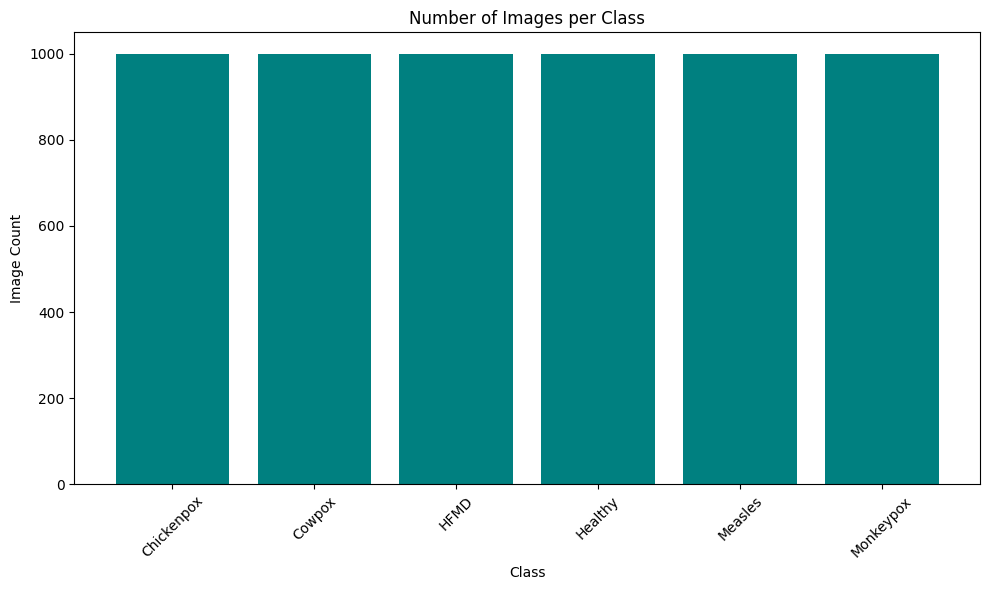

I0000 00:00:1757693381.271068      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


I0000 00:00:1757693389.968896      93 service.cc:148] XLA service 0x7e8690025b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757693389.969641      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757693390.529593      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/135 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.1493 - loss: 2.7539

I0000 00:00:1757693393.677538      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - accuracy: 0.5825 - loss: 1.1514 - val_accuracy: 0.9266 - val_loss: 0.2840
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.8932 - loss: 0.3230 - val_accuracy: 0.9715 - val_loss: 0.1290
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9463 - loss: 0.1635 - val_accuracy: 0.9783 - val_loss: 0.0818
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9680 - loss: 0.1138 - val_accuracy: 0.9850 - val_loss: 0.0674
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9799 - loss: 0.0791 - val_accuracy: 0.9918 - val_loss: 0.0469
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9861 - loss: 0.0595 - val_accuracy: 0.9918 - val_loss: 0.0348
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9884 - loss: 0.0505 - val_accuracy: 0.9945 - val_loss: 0.0249
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9897 - loss: 0.0342 - val_accuracy: 0

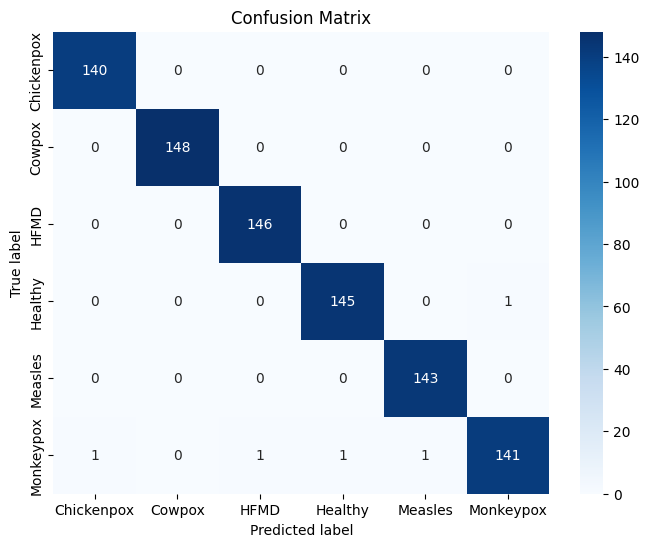

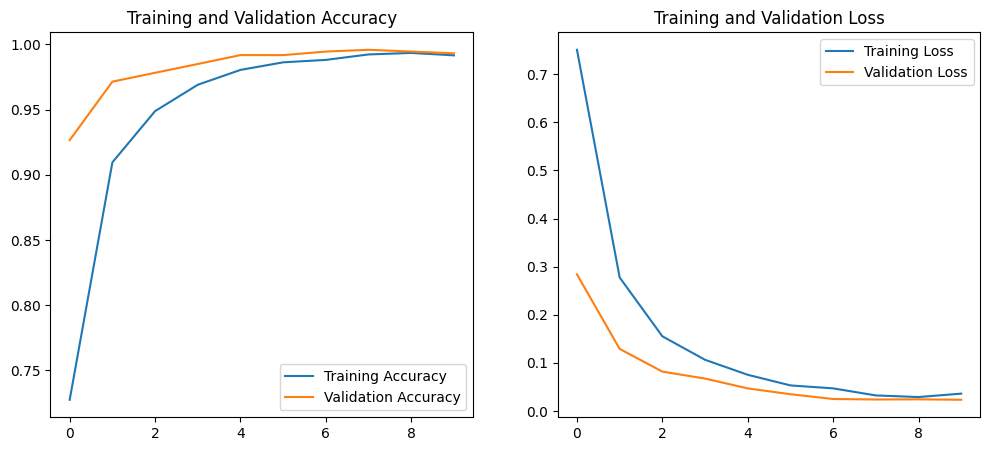

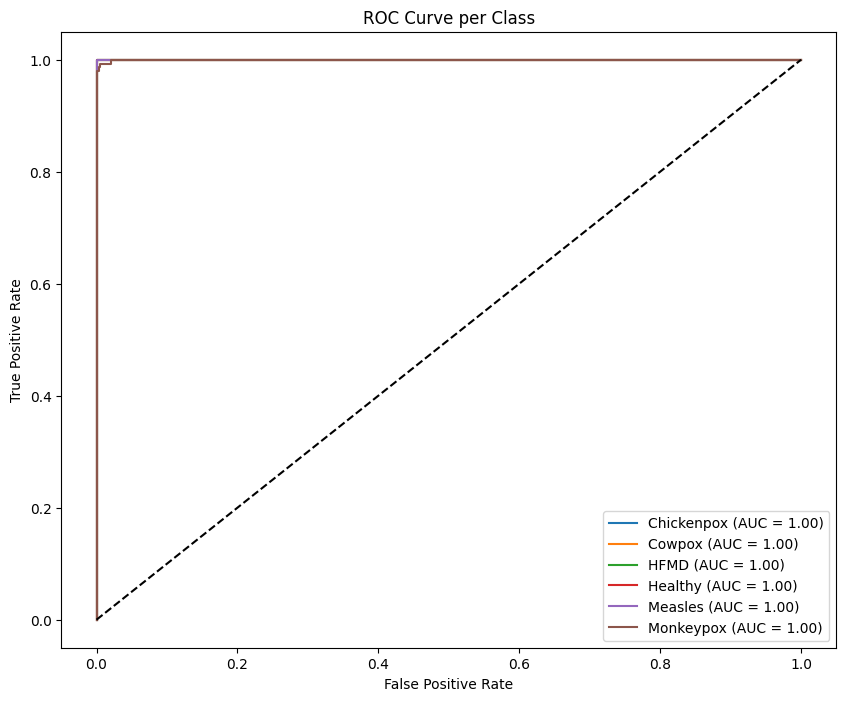

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
import os
import glob
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import to_categorical

DATASET_PATH = '/kaggle/input/monkeypox/Augmentation dataset'

classes = sorted(os.listdir(DATASET_PATH))
image_paths = []
image_labels = []

for idx, class_name in enumerate(classes):
    class_folder = os.path.join(DATASET_PATH, class_name)
    files = glob.glob(os.path.join(class_folder, '*'))
    image_paths.extend(files)
    image_labels.extend([idx] * len(files))

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

label_counts = Counter(image_labels)
print("Number of images per class:")
for idx in sorted(label_counts):
    print(f"{classes[idx]}: {label_counts[idx]} images")

plt.figure(figsize=(10, 6))
plt.bar([classes[i] for i in label_counts.keys()], label_counts.values(), color='teal')
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.15, stratify=image_labels, random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, stratify=train_labels, random_state=42)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def path_label_generator(paths, labels, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.1 if augment else 0,
        zoom_range=0.2 if augment else 0,
        horizontal_flip=augment)

    while True:
        if shuffle:
            indices = np.random.permutation(len(paths))
        else:
            indices = np.arange(len(paths))
        for start in range(0, len(paths), batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            batch_images = []
            batch_labels = []
            for i in batch_idx:
                img = tf.keras.preprocessing.image.load_img(paths[i], target_size=IMG_SIZE)
                img = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img)
                batch_labels.append(labels[i])
            batch_images = np.array(batch_images)
            batch_labels = to_categorical(batch_labels, num_classes=len(classes))
            batch_images = datagen.standardize(batch_images)
            yield batch_images, batch_labels

train_generator = path_label_generator(train_paths, train_labels, augment=True)
val_generator = path_label_generator(val_paths, val_labels, shuffle=False, augment=False)
test_generator = path_label_generator(test_paths, test_labels, shuffle=False, augment=False)

train_steps = len(train_paths) // BATCH_SIZE
val_steps = len(val_paths) // BATCH_SIZE
test_steps = len(test_paths) // BATCH_SIZE

conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
for layer in conv_base.layers:
    layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(classes), activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=EPOCHS
)

loss, accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions, true_labels = [], []
for _ in range(test_steps):
    x_batch, y_batch = next(test_generator)
    preds = model.predict(x_batch)
    predictions.append(preds)
    true_labels.append(y_batch)

predictions = np.vstack(predictions)
true_labels = np.vstack(true_labels)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=classes, labels=list(range(len(classes))))
print(report)

cm = confusion_matrix(true_classes, predicted_classes, labels=list(range(len(classes))))
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve per Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
